# Thresholding, masking and preprocessing


Fluorescence datasets represent a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing.

Today, we will explore ways to automatically define image masks -- for ROIs and other applications -- and deal with aberrations in the data that can make such analysis difficult on raw data

Episode 1: Load, understand and visualize the data  


Episode 2: Thresholding
> a) Global threshold and masking     
b) Automatic threshold detection  

Episode 3: Filtering and background subtraction
> a) The need for preprocessing  
b) Filtering out noise   
c) Background subtraction  

***
# Episode 1: Load, understand and visualize the data

First, let's import packages and set some plotting defaults


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
import seaborn as sns


### Episode 1a) Load the images


Another helpful package for navigaving your filesystem is __os__  
https://docs.python.org/3/library/os.html#module-os

In [2]:
import os

data_path = '/Users/mhturner/Desktop/Lesson2/Data/L2Data/'
dir_contents = os.listdir(data_path)
print(dir_contents)

['HAC-Cit-KRABdox_s41_t60.json', 'HAC-Cit-KRABdox_s41_t60.tif']


In [3]:
data_fn = 'HAC-Cit-KRABdox_s41_t60.tif'
full_data_path = os.path.join(data_path, data_fn)
print(full_data_path)

/Users/mhturner/Desktop/Lesson2/Data/L2Data/HAC-Cit-KRABdox_s41_t60.tif


#### <font color='red'> Exercise 1</font>: load lesson 2 data  and check the shape of the data  
use imread from skimage.io to load the .tif data file

In [4]:
from skimage.io import imread

data = imread(full_data_path)


In [5]:
data.shape

(512, 512, 3)

### Episode 1b) Load the metadata

Load the metadata, which is in JSON format

In [6]:
import json
metadata_fn = 'HAC-Cit-KRABdox_s41_t60.json'
with open(os.path.join(data_path, metadata_fn), mode='r') as metadata_file:
    meta_data = json.load(metadata_file)

Take a look at the metadata dictionary

In [7]:
meta_data

{'axes': ['XYC'],
 'channels': ['DIC', 'YFP', 'RFP'],
 'pixel_size': ['1', '1'],
 'data': ['01/01/2019'],
 'image_preprocessing': ['none'],
 'condition': ['+dox']}

Let's re-label the slices with names, instead of numbers.

In [8]:
slice = {}
for idx, channel in enumerate(meta_data['channels']):
    slice[channel] = data[:,:,idx]
    print(channel)

DIC
YFP
RFP


### Episode 1c) Visualize the images  
We'll use a slightly different plotting syntax to make __subplots__ to display each channel

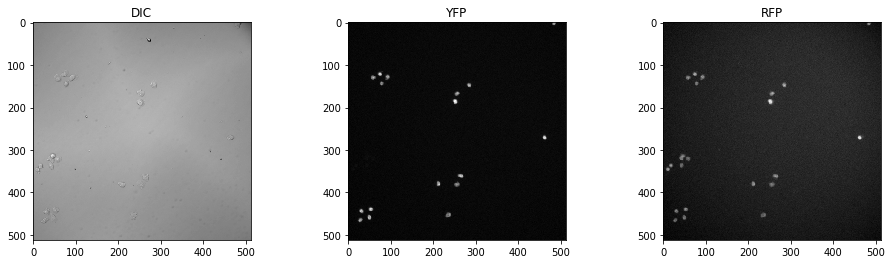

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4)) #width, height
for idx, channel in enumerate(meta_data['channels']):
    ax[idx].imshow(slice[channel], cmap='gray')
    ax[idx].set_title(channel)


***
# Episode 2: Thresholding and masking

Suppose we want to automatically select regions of interest (ROIs) from these images to, for example, count cells or measure the intensity of some fluorescent signal within the cells. One simple way to start to do this is by thresholding the image based on the pixel intensity.

To illustrate, we will focus on the YFP channel.   
Let's first split up our channels into descriptive variable names...

In [10]:
brt_data = slice['DIC']
ch1_data = slice['YFP']
ch2_data = slice['RFP']

### Part 2a) Global thresholding and masking


Let's create a __mask__ for the channel 1 image   
How should we decide on the threshold value? First let's get a sense of the range of pixel intensities present in the image by looking at a histogram

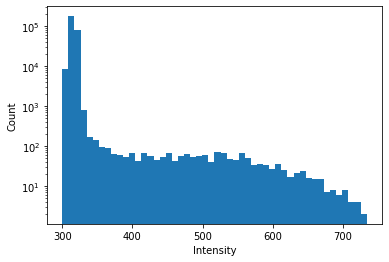

In [11]:
plt.hist(ch1_data.flatten(), bins=50) 
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.yscale('log')

OK now let's pick a threshold and make a mask...

In [12]:
thresh = 350 #325, 400
 
mask = np.zeros(ch1_data.shape)
mask[ch1_data >=thresh] = 1
print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
print(np.unique(mask))

[0. 1.]


Now we'll visualize the mask we computed

Text(0.5, 1.0, 'Mask')

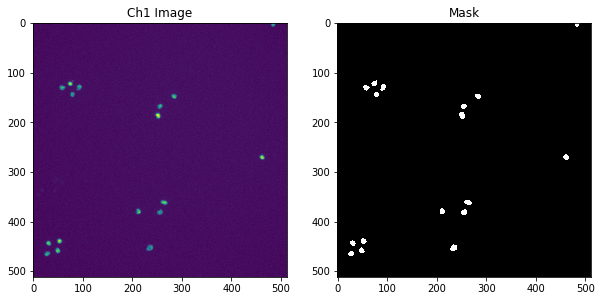

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ch1_data)
ax[0].set_title('Ch1 Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

This is a start, but the idea was to *automate* this process. Fortunately there exist several auotmatic threshold calculation methods that are included in the scikit-image library. Generally these automatic threshold methods rely on the distribution of pixel intensity values.

### Part 2b) Automatic threshold detection  

Let's use some built-in automatic threshold algorithms to define a threshold for our channel 1 image  
https://scikit-image.org/docs/dev/api/skimage.filters.html  
https://en.wikipedia.org/wiki/Otsu%27s_method  


In [15]:
from skimage.filters import threshold_otsu, threshold_yen

thresh_otsu = threshold_otsu(ch1_data)
thresh_yen = threshold_yen(ch1_data) 

print(thresh_otsu)
print(thresh_yen)


422
347


Visualize the image histogram and the automatically calculated threshold values...  

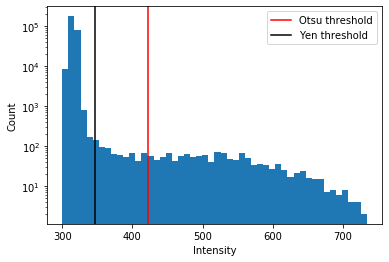

In [16]:
plt.hist(ch1_data.flatten(), bins=50)
plt.axvline(thresh_otsu, c='r', label='Otsu threshold') 
plt.axvline(thresh_yen, c='k', label='Yen threshold') 

plt.xlabel('Intensity')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()

#### <font color='red'> Exercise 2</font>: make a mask function
First, since we will be doing this a lot, let's define our own function to calculate a mask given: 1) the original image and 2) a threshold value. give the function an informative name

In [17]:
def get_mask(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    return(mask)

Now let's look at the masks generated using these automatic thresholds. 

In [18]:
mask_otsu = get_mask(ch1_data, thresh_otsu)
mask_yen = get_mask(ch1_data, thresh_yen)

Text(0.5, 1.0, 'Yen threshold')

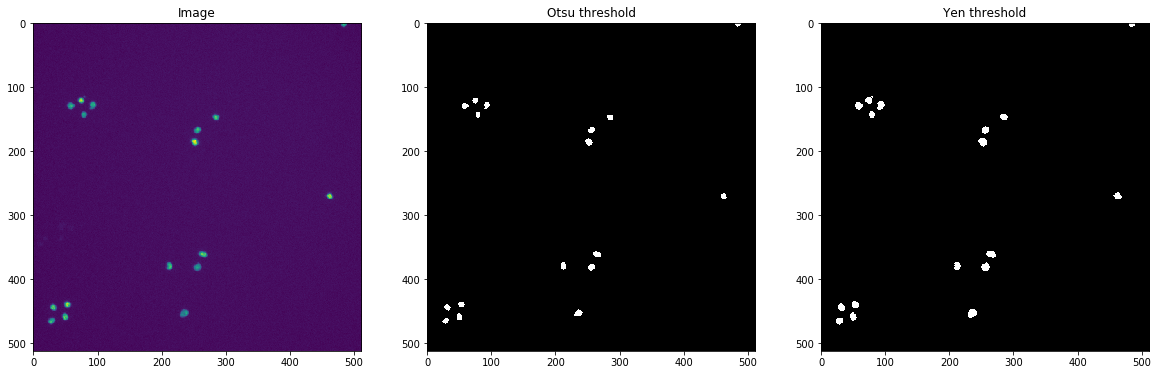

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(ch1_data)
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, cmap='gray')
ax[1].set_title('Otsu threshold')

ax[2].imshow(mask_yen, cmap='gray')
ax[2].set_title('Yen threshold')

***
# Part 3: Filtering and background subtraction

To illustrate the need for preprocessing, let's try to automatically threshold the other fluorescent channel of our data

Text(0.5, 1.0, 'Otsu threshold')

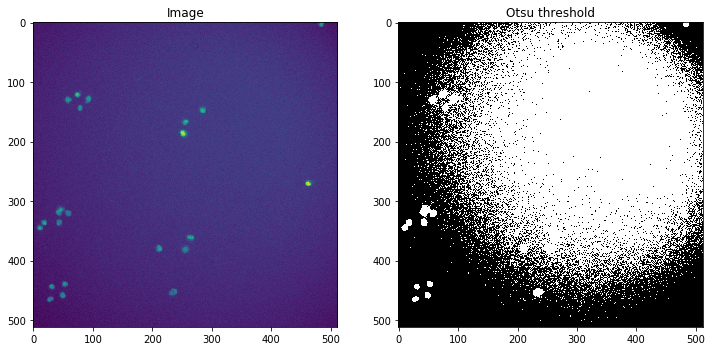

In [20]:
thresh_otsu = threshold_otsu(ch2_data)
mask_otsu = get_mask(ch2_data, thresh_otsu)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ch2_data)
ax[0].set_title('Image')

ax[1].imshow(mask_otsu, cmap='gray')
ax[1].set_title('Otsu threshold')

Our simple automatic thresholding fails for the other channel. There are at least two reasons for these failures:  
1) Salt & pepper, speckly noise  
2) A background due to uneven illumination or other optical aberrations

We'll try to get rid of the salt and pepper noise first. We'll do that by __filtering__

We need to import some packages and filters:

In [21]:
from skimage.filters.rank import minimum as min_filter
from skimage.filters.rank import median as median_filter
from skimage.morphology import disk

### Part 3b) Filtering out noise


Now, we'll try using a median filter to remove the salt-pepper noise. Can you see differences in the images? Play with the filter size and see how that affects the filtering.

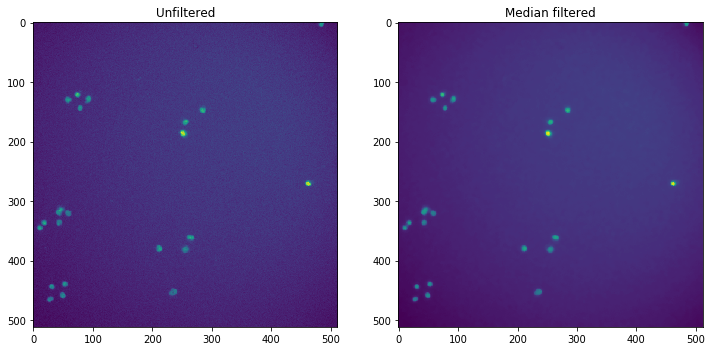

In [22]:
f_size = 4
ch2_filtered = median_filter(ch2_data, disk(f_size))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ch2_data)
ax[0].set_title('Unfiltered')
ax[1].imshow(ch2_filtered)
ax[1].set_title('Median filtered');

### Part 3c) Background subtraction

We still need to remove the un-even illumination. To do this we will subtract a background image, leaving intact the image structure we care about. First we need to compute the background using a MIN() filter.

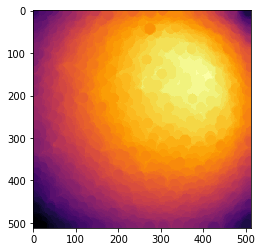

In [25]:
# See how radius needs to be larger than the largest foreground object
filter_radius = 12
ch2_background = min_filter(ch2_filtered, disk(filter_radius))
plt.imshow(ch2_background, cmap='inferno', interpolation = 'none')

#### <font color='red'> Exercise 3</font>: How does the calculated background depend on the filter size? What happens if the filter is too small? Too large?

Next, let's substract out the background from the image and visualize the result.

Text(0.5, 1.0, 'Filtered, background subtracted')

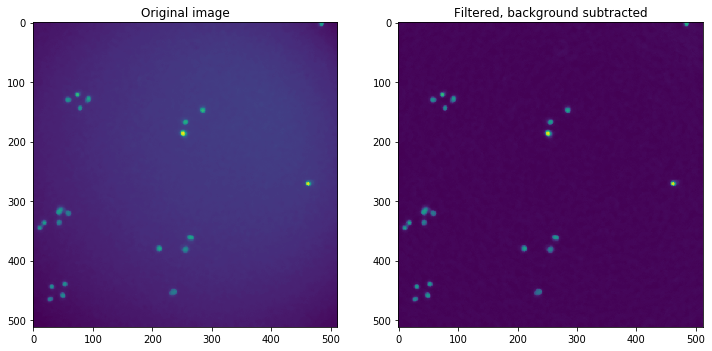

In [26]:
ch2_bgs = ch2_filtered - ch2_background
ch2_bgs[ch2_bgs<0] = 0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ch2_filtered, interpolation = 'none')
ax[0].set_title('Original image')
ax[1].imshow(ch2_bgs, interpolation = 'none')
ax[1].set_title('Filtered, background subtracted')

With our pre-processed dataset, let's try the thresholding again.

Text(0.5, 1.0, 'Otsu threshold')

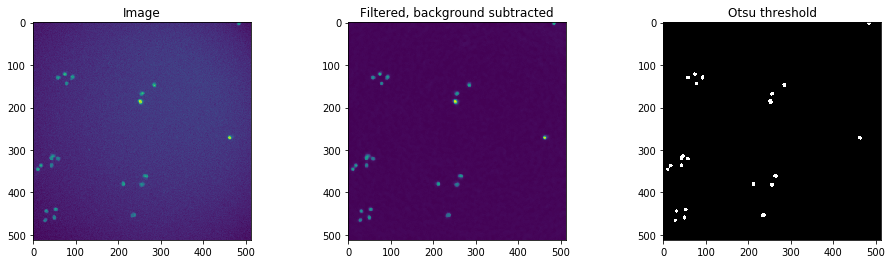

In [27]:
thresh_otsu = threshold_otsu(ch2_bgs)

mask_otsu = get_mask(ch2_bgs, thresh_otsu)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(ch2_data)
ax[0].set_title('Image')

ax[1].imshow(ch2_bgs)
ax[1].set_title('Filtered, background subtracted')

ax[2].imshow(mask_otsu, cmap='gray')
ax[2].set_title('Otsu threshold')


### Bonus: The limits of global intensity thresholding

We haven't yet tried any processing on our brightfield channel. Let's see how the methods we tried above work on these data

Text(0.5, 1.0, 'Mask')

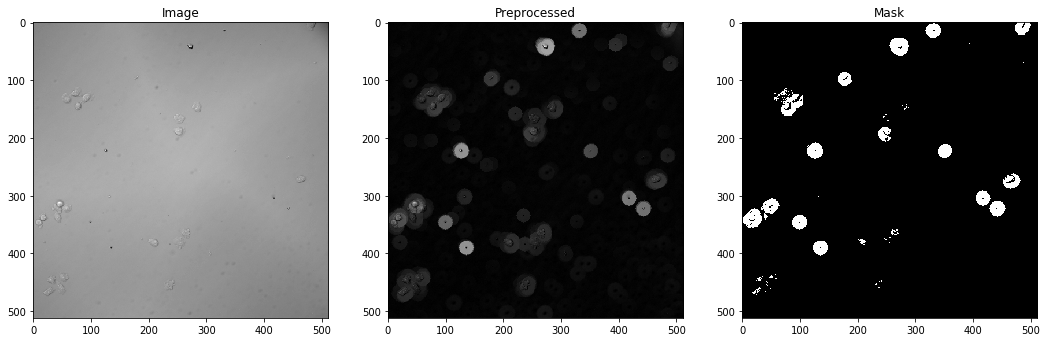

In [29]:
filter_radius = 12
brt_background = min_filter(brt_data, disk(filter_radius))

brt_bgs = brt_data - brt_background
brt_bgs[brt_bgs<0] = 0

thresh = threshold_otsu(brt_bgs)
mask = get_mask(brt_bgs, thresh)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(brt_data, cmap='gray')
ax[0].set_title('Image')

ax[1].imshow(brt_bgs, cmap='gray')
ax[1].set_title('Preprocessed')

ax[2].imshow(mask, cmap='gray')
ax[2].set_title('Mask')

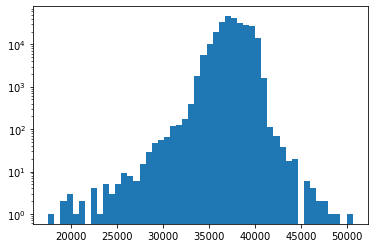

In [30]:
plt.hist(brt_data.flatten(), bins=50);
plt.yscale('log')

#### Edge / contrast-enhancing filters   
The above methods rely on the intensity of each pixel, but we see the cells in the DIC channel with our eyes because of the contrast in the image. To pick out high contrast regions we can try a edge-detection filter

Text(0.5, 1.0, 'Mask')

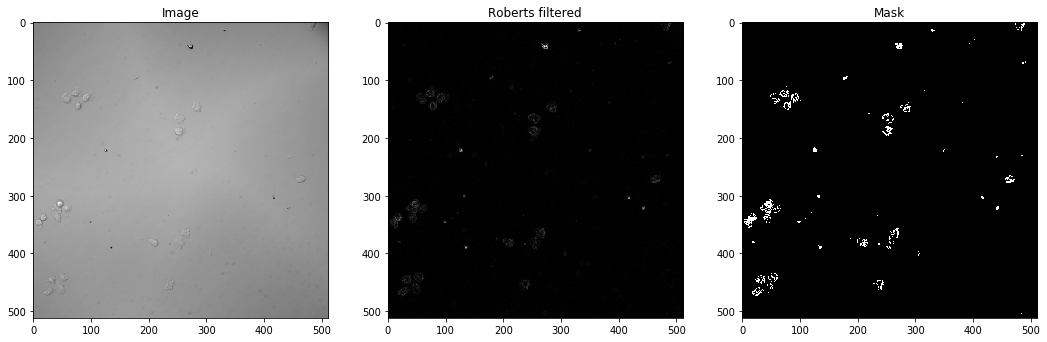

In [33]:
from skimage.filters import roberts

brt_edge = roberts(brt_data)
thresh = threshold_otsu(brt_edge)
mask = get_mask(brt_edge, thresh)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(brt_data, cmap='gray')
ax[0].set_title('Image')

ax[1].imshow(brt_edge, cmap='gray')
ax[1].set_title('Roberts filtered')

ax[2].imshow(mask, cmap='gray')
ax[2].set_title('Mask')

In [ ]:
plt.hist(brt_edge.flatten(), bins=50)
plt.axvline(thresh, c='r', label='Otsu threshold') 
plt.yscale('log')